In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split

from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model, load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from tensorflow.keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [2]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/thedownhill/art-images-drawings-painting-sculpture-engraving")
od.download("https://www.kaggle.com/datasets/valkling/inception-resnet-v2-weights")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mohammedzaki3
Your Kaggle Key: ··········


100%|██████████| 583M/583M [00:04<00:00, 122MB/s]



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mohammedzaki3
Your Kaggle Key: ··········


100%|██████████| 199M/199M [00:01<00:00, 108MB/s]


In [3]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
INPUT_SHAPE=(IMG_HEIGHT, IMG_WIDTH, 1)
TRAIN_PATH = '/content/art-images-drawings-painting-sculpture-engraving/dataset/dataset_updated/training_set/painting/'

train_ids = next(os.walk(TRAIN_PATH))[2]

In [4]:
%%time
X_train = np.zeros((len(train_ids)-86, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
missing_count = 0
print('Getting train images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_+''
    try:
        img = imread(path)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n-missing_count] = img
    except:
#         print(" Problem with: "+path)
        missing_count += 1

X_train = X_train.astype('float32') / 255.
print("Total missing: "+ str(missing_count))

Getting train images ... 


100%|██████████| 2128/2128 [00:47<00:00, 45.11it/s]


Total missing: 86
CPU times: user 33.3 s, sys: 27.5 s, total: 1min
Wall time: 47.9 s


In [5]:
Xtrain, Xtest = train_test_split(X_train, test_size=20, random_state=seed)


In [6]:
def Colorize():
    print(tf.executing_eagerly())
    embed_input = Input(shape=(1000,))
    
    #Encoder
    encoder_input = Input(shape=(256, 256, 1,))
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_input)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(128, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(128, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same',strides=1)(encoder_output)
    encoder_output = MaxPooling2D((2, 2), padding='same')(encoder_output)
    encoder_output = Conv2D(256, (4,4), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
    
    #Fusion
    fusion_output = RepeatVector(32 * 32)(embed_input) 
    fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
    fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
    fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)
    
    #Decoder
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    decoder_output = Conv2D(64, (4,4), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(32, (2,2), activation='relu', padding='same')(decoder_output)
    decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
    decoder_output = UpSampling2D((2, 2))(decoder_output)
    return Model(inputs=[encoder_input, embed_input], outputs=decoder_output)
# import keras
# from tensorflow.keras import *
# input_img = keras.Input(shape=(256, 256, 3))

# x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
# x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# #encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
# encoded = x
# # at this point the representation is (4, 4, 8) i.e. 128-dimensional

# x = layers.Conv2DTranspose(64, (3, 3), strides=(2,2), activation='relu', padding='same')(encoded)
# decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# model = keras.Model(input_img, decoded)
# # loss_fn = keras.losses.SparseCategoricalCrossentropy()
# model.compile(optimizer='adam', loss='mse')
# model.summary()

model = Colorize()
model.summary()

True
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 12  1280        ['input_2[0][0]']                
                                8)                                                                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 12  0           ['conv2d[0][0]']                 
                                8)                                                       

In [7]:
# inception = InceptionResNetV2(weights=None, include_top=True)
# inception.load_weights('/content/inception-resnet-v2-weights/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')
# inception.run_eagerly = False
# inception.graph = tf.compat.v1.get_default_graph()

In [8]:
inception = InceptionResNetV2(weights='imagenet', include_top=True )
inception.run_eagerly = False
inception.graph = tf.compat.v1.get_default_graph()

225209952/225209952 [==============================] - 2s 0us/step


In [9]:
# def create_inception_embedding(grayscaled_rgb):
#     grayscaled_rgb_resized = []
#     for i in grayscaled_rgb:
#         i = resize(i, (299, 299, 3), mode='constant')
#         grayscaled_rgb_resized.append(i)
#     grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
#     grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    
#     with inception.graph.as_default():
#       inception.run_eagerly = True
#       embed = inception.predict(grayscaled_rgb_resized)
#     return embed

# # Image transformer
# datagen = ImageDataGenerator(
#         shear_range=0.2,
#         zoom_range=0.2,
#         rotation_range=20,
#         horizontal_flip=True)

# #Generate training data
# batch_size = 10

# def image_a_b_gen(batch_size):
#     inception.run_eagerly = True
#     for batch in datagen.flow(Xtrain, batch_size=batch_size):
#         grayscaled_rgb = gray2rgb(rgb2gray(batch))
#         embed = create_inception_embedding(grayscaled_rgb)
#         lab_batch = rgb2lab(batch)
#         X_batch = lab_batch[:,:,:,0]
#         X_batch = X_batch.reshape(X_batch.shape+(1,))
#         Y_batch = lab_batch[:,:,:,1:] / 128
#         yield ([X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch)


# #Train model      
# model.compile(optimizer='rmsprop', loss='mse' , run_eagerly=True)
# model.fit(image_a_b_gen(batch_size), epochs=1, steps_per_epoch=1)


In [10]:
Xtest.shape

(20, 256, 256, 3)

#Solution

In [11]:
from scipy.sparse.coo import matrix
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    
    
    #with inception.graph.as_default():   #Returns a default graph for this thread 
    inception.run_eagerly = True
    embed = inception.predict(grayscaled_rgb_resized)
    return embed

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Generate training data
batch_size = 10

def image_a_b_gen(batch_size):
    inception.run_eagerly = True
    for batch in datagen.flow(Xtrain[:300], batch_size=batch_size):
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_inception_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield ([X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch)


#Train model   
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)   
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'],run_eagerly=True)
model.fit(image_a_b_gen(16), epochs=500,steps_per_epoch=5)


Streaming output truncated to the last 5000 lines.
5/5 [==============================] - 8s 2s/step - loss: 0.0052 - accuracy: 0.8366
Epoch 85/500
5/5 [==============================] - 8s 2s/step - loss: 0.0054 - accuracy: 0.8784
Epoch 86/500
5/5 [==============================] - 8s 2s/step - loss: 0.0045 - accuracy: 0.8612
Epoch 87/500
5/5 [==============================] - 8s 2s/step - loss: 0.0054 - accuracy: 0.8483
Epoch 88/500
5/5 [==============================] - 8s 2s/step - loss: 0.0052 - accuracy: 0.8418
Epoch 89/500
5/5 [==============================] - 8s 2s/step - loss: 0.0052 - accuracy: 0.8825
Epoch 90/500
5/5 [==============================] - 8s 2s/step - loss: 0.0048 - accuracy: 0.8777
Epoch 91/500
5/5 [==============================] - 8s 2s/step - loss: 0.0055 - accuracy: 0.8495
Epoch 92/500
5/5 [==============================] - 8s 2s/step - loss: 0.0052 - accuracy: 0.8771
Epoch 93/500
5/5 [==============================] - 8s 2s/step - loss: 0.0046 - accuracy:

In [12]:
sample = Xtest
color_me = gray2rgb(rgb2gray(sample))
color_me_embed = create_inception_embedding(color_me)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

output = model.predict([color_me, color_me_embed])
output = output * 128

decoded_imgs = np.zeros((len(output),256, 256, 3))

for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    decoded_imgs[i] = lab2rgb(cur)
    cv2.imwrite("img_"+str(i)+".jpg", lab2rgb(cur))

1/1 [==============================] - 3s 3s/step


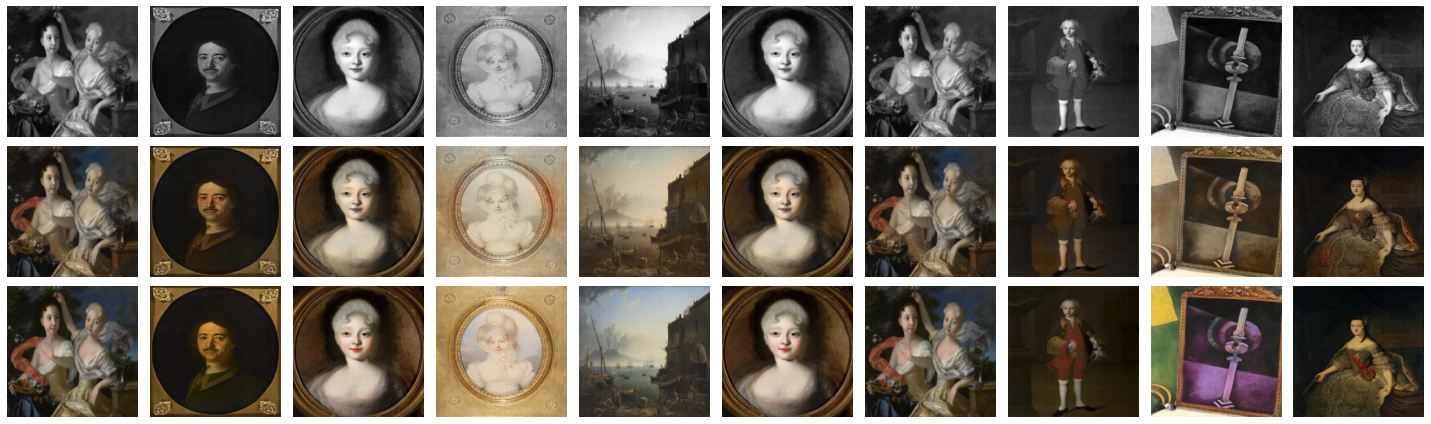

In [13]:
plt.figure(figsize=(20, 6))
for i in range(10):
    # grayscale
    plt.subplot(3, 10, i + 1)
    plt.imshow(rgb2gray(Xtest)[i].reshape(256, 256))
    plt.gray()
    plt.axis('off')
 
    # recolorization
    plt.subplot(3, 10, i + 1 +10)
    plt.imshow(decoded_imgs[i].reshape(256, 256,3))
    plt.axis('off')
    
    # original
    plt.subplot(3, 10, i + 1 + 20)
    plt.imshow(Xtest[i].reshape(256, 256,3))
    plt.axis('off')
 
plt.tight_layout()
plt.show()

In [14]:
decoded_imgs.shape

(20, 256, 256, 3)

In [15]:
Xtest.shape

(20, 256, 256, 3)